In [1]:
import numpy as np

import tensorflow as tf

from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    optimizers,
)

from utils import display

from g_model import WGANGP, ImageGenerator

In [2]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 64
NUM_FEATURES = 64
Z_DIM = 300
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 100
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

In [3]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "/home/shea.durgin/Generative_AI/Assignments/images",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 63565 files belonging to 1 classes.


In [4]:
# Preprocess the data
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))
train = train.repeat()

In [5]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)
#critic.summary()

In [6]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh"
)(x)
generator = models.Model(generator_input, generator_output)
#generator.summary()

In [7]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [8]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [9]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

Epoch 1/100
500/500 [==============================] - ETA: 0s - c_loss: -23.2736 - c_wass_loss: -30.0144 - c_gp: 0.6741 - g_loss: -2.8312
Saved to ./output/generated_img_000.png


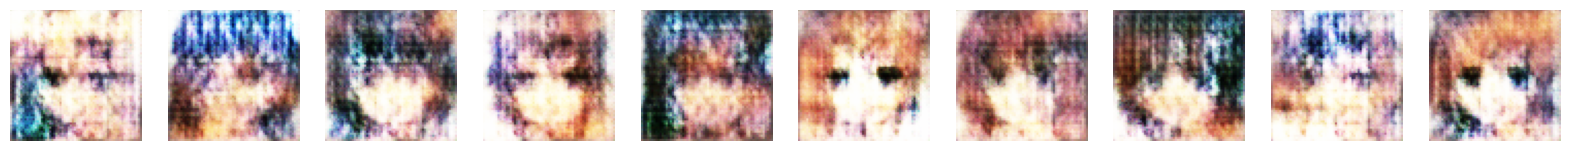

500/500 [==============================] - 65s 115ms/step - c_loss: -23.2736 - c_wass_loss: -30.0144 - c_gp: 0.6741 - g_loss: -2.8312
Epoch 2/100
500/500 [==============================] - 58s 116ms/step - c_loss: -11.7209 - c_wass_loss: -13.7826 - c_gp: 0.2062 - g_loss: -6.2459
Epoch 3/100
500/500 [==============================] - 59s 117ms/step - c_loss: -7.8345 - c_wass_loss: -8.9208 - c_gp: 0.1086 - g_loss: -0.0784
Epoch 4/100
500/500 [==============================] - 62s 124ms/step - c_loss: -6.0195 - c_wass_loss: -6.8586 - c_gp: 0.0839 - g_loss: -8.0557
Epoch 5/100
500/500 [==============================] - 65s 131ms/step - c_loss: -5.8328 - c_wass_loss: -6.5732 - c_gp: 0.0740 - g_loss: -14.7040
Epoch 6/100
500/500 [==============================] - 63s 126ms/step - c_loss: -5.0721 - c_wass_loss: -5.7419 - c_gp: 0.0670 - g_loss: 3.9431
Epoch 7/100
500/500 [==============================] - 59s 117ms/step - c_loss: -5.2117 - c_wass_loss: -5.7896 - c_gp: 0.0578 - g_loss: -0.3412


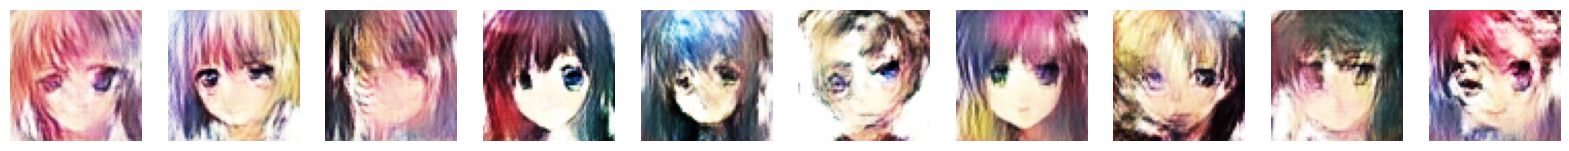

500/500 [==============================] - 61s 121ms/step - c_loss: -3.4103 - c_wass_loss: -3.8372 - c_gp: 0.0427 - g_loss: 20.8206
Epoch 12/100
500/500 [==============================] - 58s 117ms/step - c_loss: -2.4525 - c_wass_loss: -2.8384 - c_gp: 0.0386 - g_loss: 41.6058
Epoch 13/100
500/500 [==============================] - 59s 118ms/step - c_loss: -3.4255 - c_wass_loss: -3.7824 - c_gp: 0.0357 - g_loss: 32.2048
Epoch 14/100
500/500 [==============================] - 56s 112ms/step - c_loss: -2.6154 - c_wass_loss: -2.9623 - c_gp: 0.0347 - g_loss: 21.7070
Epoch 15/100
500/500 [==============================] - 59s 118ms/step - c_loss: -3.2285 - c_wass_loss: -3.5489 - c_gp: 0.0320 - g_loss: 25.0003
Epoch 16/100
500/500 [==============================] - 64s 128ms/step - c_loss: -2.9848 - c_wass_loss: -3.2616 - c_gp: 0.0277 - g_loss: 60.2991
Epoch 17/100
500/500 [==============================] - 58s 115ms/step - c_loss: -3.2578 - c_wass_loss: -3.5633 - c_gp: 0.0306 - g_loss: 152.83

In [ ]:
wgangp.fit(
    train,
    epochs=EPOCHS,
    steps_per_epoch=500,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)
# Save the final models
generator.save("./models/generator")
critic.save("./models/critic")

In [ ]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgangp.generator.predict(z_sample)
display(imgs, cmap=None)